Connected to base (Python 3.11.5)

输出持仓


<ipython-input-1-bc8c006765fc>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holding['市值占净值%']=pd.to_numeric(holding['市值占净值%'],errors='coerce')


,市值,市值占净值%,总投资额,所属策略,估值增值
潼骁新资产,9596327.14,28.2828,5928448.97,纯债策略,3667878.17
国源不绝聚配专享2号,3740812.17,11.0251,3159952.21,股票多头,580859.96
跃威锦鑫一号,2710197.87,7.9876,2500000.00,期权策略,210197.87
致远稳健三十号,2160756.04,6.3683,2100000.00,市场中性策略,60756.04
图斯和贞,2874700.42,8.4725,2840000.00,股票多头,34700.42
千衍九凌1号,2013870.13,5.9354,2000000.00,CTA策略,13870.13
现金,2862589.74,NaN,2862589.74,NaN,0.00
远澜红枫私享12号,1917742.25,5.6521,2000000.00,CTA策略,-82257.75
信弘罄宜1号,1885235.10,5.5563,2000000.00,CTA策略,-114764.90
宏锡量化CTA30号六期,NaN,NaN,3089975.00,CTA策略,NaN


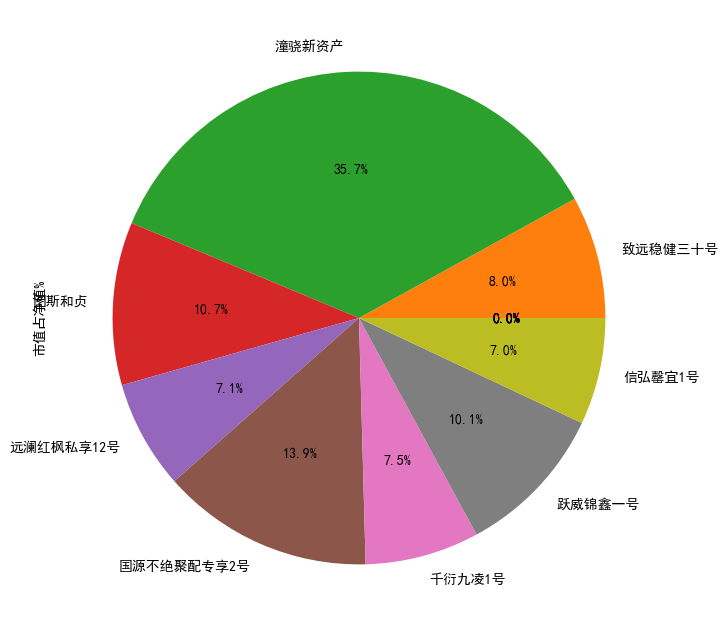

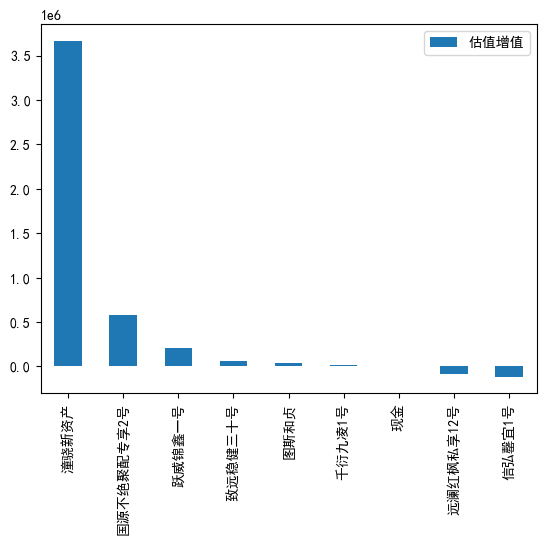

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from datetime import datetime
import riskfolio as rp
 
#图片显示字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为SimHei
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时'-'显示为方块的问题


class FOF_Analyzing():
    
    def PY_FOF_Holding(self,Date):

        Filepath=r'D:\FOF持仓程序\朴元估值表'

        Ininital_Investment_Path=r'D:\FOF持仓程序\原始数据'

        File=pd.read_excel(Filepath+'\\'+'朴元进取一期私募证券投资基金_估值表_四级科目_'+Date+'.xls',skiprows=3,index_col=[0])
        
        #现金项目代码
        cash_code=['1002','1031']

        #私募基金项目代码
        hedge_fund_codes=[]

        for i in File.index.tolist():

            if len(i)==14 and str(11090601) in i:
                
                hedge_fund_codes.append(i)

        #取出现金占比

        cash_df=File.loc[cash_code]

        cash_df=cash_df[['科目名称','市值','市值占净值%']]

        cash_df.loc["现金",:]=cash_df.sum()

        cash_df.loc["现金","科目名称"]='现金'

        cash_df=cash_df.loc[["现金"]]


        #取出私募占比

        hedge_fund_df=File.loc[hedge_fund_codes]

        hedge_fund_df=hedge_fund_df[['科目名称','市值','市值占净值%']]

        #取出成本
        
        Ininital_Investment_df=pd.read_excel(Ininital_Investment_Path+'\\'+'朴元进取一期成本.xlsx',index_col=[0])

        #持仓占比

        total=pd.concat([cash_df,hedge_fund_df],axis=0)

        total.index=total.loc[:,"科目名称"]

        total=pd.concat([total,Ininital_Investment_df],axis=1)

        holding=total[['市值','市值占净值%','总投资额','所属策略']]

        holding['市值占净值%']=pd.to_numeric(holding['市值占净值%'],errors='coerce')

        #取出私募成本与市值

        hedge_fund_df_total=File.loc[hedge_fund_codes]

        hedge_fund_df_total.index=hedge_fund_df.loc[:,"科目名称"]

        profit_loss=hedge_fund_df_total[['估值增值']]

        profit_loss=profit_loss.sort_values(by='估值增值',ascending=False)

        result=pd.concat([holding,profit_loss],axis=1)

        result.loc["现金","总投资额"]=result.loc["现金","市值"]

        result.loc[:,"估值增值"]=result.loc[:,"市值"]-result.loc[:,"总投资额"]

        strategy_holding=result.groupby('所属策略')['市值占净值%'].sum()
        
        strategy_holding_df=strategy_holding.to_frame(name='市值占比')

        pl_index=result.index
        
        names=[]
        #修改名字，去掉私募证券投资基金
        for i in pl_index:

            name=i.replace('私募证券投资基金','')

            names.append(name)

        result.index=names

        #画图
        result['市值占净值%'].plot.pie(autopct='%1.1f%%', figsize=(8, 8))

        result=result.sort_values(by='估值增值',ascending=False)

        result[['估值增值']].dropna().plot.bar()

        print('输出持仓')

        return result

    def PY_FOF_Holding_Analyze(self,Date):
        
        #提取持仓信息
        Holding=self.PY_FOF_Holding(Date)

        #定义进攻端基金名称
        Offence_Position=['国源不绝聚配专享2号','宏锡量化CTA30号六期','艮岳吉祥中证500指数增强1号','图灵创业板指数增强1号','千衍九凌1号','远澜红枫私享12号','蒙玺科创50指数量化1号']
        #定义防守端基金名称
        Defence_Position=['图斯和贞','鸣熙致远二十号','蒙玺分形2号','跃威锦鑫一号','潼骁新资产','致远稳健三十号','现金']

        #提取进攻端和防守端的信息
        OD_Holding=pd.DataFrame(columns=['持仓占比%'])

        Offence_Position_Holding=Holding.loc[Offence_Position]

        Defence_Position_Holding=Holding.loc[Defence_Position]

        Offence_Holding_Total=Offence_Position_Holding.loc[:,"市值占净值%"].sum()

        Defence_Holding_Total=Defence_Position_Holding.loc[:,"市值占净值%"].sum()

        OD_Holding.loc["进攻端",:]=Offence_Holding_Total

        OD_Holding.loc['防守端',:] = Defence_Holding_Total

        #画图
        print('输出进攻端')

        plt.figure()
        Offence_Position_Holding["市值占净值%"].plot.pie(autopct='%1.1f%%', figsize=(8, 8))

        print('输出防守端')

        plt.figure()
        Defence_Position_Holding["市值占净值%"].plot.pie(autopct='%1.1f%%', figsize=(8, 8))

        print('输出进攻与防守端')

        plt.figure()

        OD_Holding['持仓占比%'].plot.pie(autopct='%1.1f%%', figsize=(8, 8))

        return
    
    def Calculate_risk_contribution(self,df, weights, window):
        """
        计算各个基金对整体风险的贡献度
        
        参数:
        df (DataFrame): 每个基金的净值的时间序列数据
        weights (dict): 每只基金当前持有的权重，例如 {'Fund1': 0.4, 'Fund2': 0.3, 'Fund3': 0.3}
        window (int): 计算数据的窗口期，例如滚动1年或6个月的数据
        
        返回:
        DataFrame: 各个基金的风险贡献度
        """
        # 确保基金的权重总和为1
        assert np.isclose(sum(weights.values()), 1), "权重总和必须为1"
        
        # 确保每只基金都有权重
        assert set(df.columns) == set(weights.keys()), "所有基金都需要有权重"
        
        # 创建一个空的DataFrame来存储风险贡献度
        risk_contributions =[]

        for i in range(window, len(df)):
            # 提取滚动窗口期的数据
            sub_df = df.iloc[i-window:i]
            
            # 计算收益率
            returns = sub_df.pct_change().dropna()
            
            # 计算协方差矩阵
            cov_matrix = returns.cov()

            # 计算风险贡献度
            risk_contribution = rp.Risk_Contribution(w=np.array(list(weights.values())), cov=cov_matrix, returns=returns)

            # 将风险贡献度转换为 DataFrame，并添加到结果 DataFrame
            risk_contributions.append(pd.DataFrame([risk_contribution], columns=df.columns, index=[df.index[i]]))

        risk_contributions=pd.concat(risk_contributions)

        risk_contributions=risk_contributions.T

        return risk_contributions

    def Extract_Sheets_to_Dfs(self,file_path, sheet_names):
        """
            从Excel文件中读取指定的sheet，并将它们转换为dataframe

            参数:
            file_path (str): Excel文件的路径。例如："data.xlsx"
            sheet_names (list): 要提取的sheet的名称列表。例如：["Sheet1", "Sheet2", "Sheet3"]

            返回值:
            dict: 字典，其中的键是sheet的名称，值是对应的dataframe。例如：{"Sheet1": df1, "Sheet2": df2, "Sheet3": df3}
            """

        #结果输出路径

        export_path=r'D:\FOF持仓程序\华睿下投子基金净值'
        os.chdir(export_path)
        # 创建一个空字典，用于存放最后的结果
        dfs = {}

        # 使用pandas的ExcelFile函数打开Excel文件
        xls = pd.ExcelFile(file_path)

        # 遍历用户提供的sheet名称列表
        for sheet_name in sheet_names:
            # 检查当前sheet名称是否存在于Excel文件的sheet列表中
            if sheet_name in xls.sheet_names:
                # 如果存在，使用pandas的parse函数读取这个sheet的数据并转换为dataframe
                df = xls.parse(sheet_name)

                # 将这个dataframe添加到结果字典中，键是sheet的名称，值是dataframe
                dfs[sheet_name] = df
            else:
                # 如果当前sheet名称不存在于Excel文件的sheet列表中，打印一个错误信息
                print(f"Sheet {sheet_name} not found in {file_path}")
        
        #使用遍历将选出的dataframe一个一个导出来

        for i in sheet_names:
            try:
                df=dfs[i]
                df=df.iloc[2:,:]
                df.index=pd.to_datetime(df.iloc[:,0])
                df=df[[df.columns[1]]]
                df.to_excel(i+'.xlsx')
            except:
                print(i+'出现错误')
        print('输出完成')
        return 

    def PY_FOF_Risk_Weight(self,Date):

        Holding=self.PY_FOF_Holding(Date)

        port_holding=Holding[['市值占净值%']]

        port_holding=port_holding.iloc[:-2,:]

        data_path=r'D:\FOF持仓程序\子净值数据'

        DF=[]
        #合并所有私募基金数据

        for i in os.listdir(data_path):

            data=pd.read_excel(data_path+'\\'+i,index_col=[0])

            data.index=pd.to_datetime(data.index)

            DF.append(data)
        
        DF=pd.concat(DF,axis=1)

        DF=DF.dropna()

        DF.loc[:,"其他"]=1

        window=len(DF)-1
        # 
        # weights (dict): 每只基金当前持有的权重，例如 {'Fund1': 0.4, 'Fund2': 0.3, 'Fund3': 0.3}
        port_holding[["市值占净值%"]]= port_holding[["市值占净值%"]]/100
        
        port_holding.loc["其他",:]=1-port_holding['市值占净值%'].sum()

        weights=port_holding["市值占净值%"].to_dict()

        risk_contribution=self.Calculate_risk_contribution(DF,weights,window)

        result=risk_contribution.iloc[[-1]]

        result=risk_contribution.T

        result=result/result.sum()

        result.columns=['risk_contribution']

        result=result.sort_values(by='risk_contribution',ascending=False)

        plt.figure()

        result['risk_contribution'].plot.pie(autopct='%1.1f%%', figsize=(8, 8),labels=None)

        num_of_labels = len(result.index)

        plt.legend(labels=result.index, loc="center left", bbox_to_anchor=(1, 0.5))     


        #加入相关性分析

        DF_Pct=DF.pct_change(1)

        corr=DF_Pct.corr()

        plt.figure(figsize=(8,6))

        sns.heatmap(corr,annot=True,xticklabels=corr.columns.values,yticklabels=corr.columns.values,cmap='coolwarm') 

        plt.title("Correlation Heatmap")

        plt.show()           

        return result
      
    def HRWJ_1_FOF_Holding(self,Date):

        #将日期转换为’20231010'的格式 

        date_obj=datetime.strptime(Date,'%Y-%m-%d')

        formatted_date_str = date_obj.strftime('%Y%m%d')

        Filepath=r'D:\FOF持仓程序\华睿稳健FOF一号估值表'

        File=pd.read_excel(Filepath+'\\'+'SB9144_华闻期货华睿稳健FOF一号集合资产管理计划_资产估值表_'+formatted_date_str+'_4级.xls',skiprows=4,index_col=[0])
        
        #现金项目代码
        cash_code=['1002']

        #交易类基金投资_现金类
        money_fund_code=[]

        for i in File.index.tolist():

            if len(i)==21 and "1105.24.01" in i:

                money_fund_code.append(i)

        #私募基金项目代码
        hedge_fund_codes=[]

        for i in File.index.tolist():

            if len(i)==21 and "1108.02.01" in i:
                
                hedge_fund_codes.append(i)

        #取出现金占比

        cash_df=File.loc[cash_code]

        cash_df=cash_df[['科目名称','市值占比','市值.1']]

        #取出货基占比

        money_fund_df=File.loc[money_fund_code]

        money_fund_df=money_fund_df[['科目名称','市值占比','市值.1']]

        #取出私募占比

        hedge_fund_df=File.loc[hedge_fund_codes]

        hedge_fund_df=hedge_fund_df[['科目名称','市值占比','市值.1']]
        
        #持仓占比

        total=pd.concat([cash_df,money_fund_df,hedge_fund_df],axis=0)

        total.index=total.loc[:,"科目名称"]

        holding=total[['市值占比']]

        holding['市值占比']=pd.to_numeric(holding['市值占比'],errors='coerce')

        #持仓市值

        market_value=total[['市值.1']]

        market_value['市值.1']=pd.to_numeric(market_value['市值.1'],errors='coerce')


        #取出子基金成本

        path=r'D:\FOF持仓程序\原始数据'

        initial_investment=pd.read_excel(path+'\\'+'华睿稳健FOF一号成本.xlsx',index_col=[0])

        result=pd.concat([initial_investment,holding,market_value],axis=1)

        result.loc["银行存款","总投资额"]= result.loc["银行存款","市值.1"]

        result.loc[:,"估值增值"]=result.loc[:,"市值.1"]-result.loc[:,"总投资额"]

        pl_index=result.index
        
        names=[]
        #修改名字，去掉私募证券投资基金
        for i in pl_index:

            name=i.replace('私募证券投资基金','')

            names.append(name)

        result.index=names

        result.columns=['总投资额','所属策略','市值占比','持仓市值','持仓盈亏']

        result.loc["银行存款","所属策略"]='现金'

        strategy_holding=result.groupby('所属策略')['市值占比'].sum()
        
        strategy_holding_df=strategy_holding.to_frame(name='市值占比')
        

        #画图并输出到本地

        export_path=r'D:\FOF持仓程序\结果'

        os.chdir(export_path)

        plt.figure(figsize=(8, 8))

        result['市值占比'].plot.pie(autopct='%1.1f%%', figsize=(8, 8))
        plt.savefig('华睿稳健市值占比.jpg')

        plt.figure(figsize=(8, 8))

        strategy_holding_df['市值占比'].plot.pie(autopct='%1.1f%%', figsize=(8, 8))
        plt.savefig('华睿稳健策略市值占比.jpg')


        plt.figure(figsize=(10, 10))
        result=result.sort_values(by='持仓市值',ascending=False)
        result['持仓市值'].plot.bar(color='darkred')
        plt.savefig('华睿稳健持仓市值.jpg')

        result=result.sort_values(by='持仓盈亏',ascending=False)

        plt.figure(figsize=(10, 10))

        result[['持仓盈亏']].dropna().plot.bar(color='midnightblue')

        plt.savefig('华睿稳健持仓盈亏.jpg')

        print('输出持仓')

        result.loc["总和",:]=result.sum()

        result=result.round(2)

        print(result)
        
        total=pd.concat([result,strategy_holding_df],axis=0)
        
        total.to_excel('华睿稳健持仓情况.xlsx')
        
        return total

    def HRWJ_1_FOF_Risk_Weight(self,Date):

        Holding=self.HRWJ_1_FOF_Holding(Date)

        Holding=Holding.dropna()

        port_holding=Holding[['市值占比']]

        port_holding=port_holding.iloc[:-1,:]

        data_path=r'D:\FOF持仓程序\华睿下投子基金净值'

        DF=[]
        #合并所有私募基金数据

        for i in os.listdir(data_path):

            data=pd.read_excel(data_path+'\\'+i,index_col=[0])

            data.index=pd.to_datetime(data.index)
                # Check if index has duplicates
            if data.index.duplicated().any():
                print(f"Duplicate indices found in file: {i}")
                # If you want to remove duplicates and keep the first occurrence:
                data = data[~data.index.duplicated(keep='first')]
                # Or, if you want to reset the index:
                # data.reset_index(drop=True, inplace=True)
        
            DF.append(data)

        DF=pd.concat(DF,axis=1)

        DF=DF.dropna()
        
        #对齐名字
        port_holding.index=DF.columns

        window=len(DF)-1
        # 
        # weights (dict): 每只基金当前持有的权重，例如 {'Fund1': 0.4, 'Fund2': 0.3, 'Fund3': 0.3}
        
        weights=port_holding["市值占比"].round(2).to_dict()

        risk_contribution=self.Calculate_risk_contribution(DF,weights,window)

        risk_contribution.columns=['risk_contribution']

        result=risk_contribution.sort_values(by='risk_contribution',ascending=False)

        export_path=r'D:\FOF持仓程序\结果'

        os.chdir(export_path)

        plt.figure()

        result.plot.bar(figsize=(10, 10))

        plt.savefig('风险贡献度.jpg')

        #加入相关性分析

        DF_Pct=DF.pct_change(1)

        corr=DF_Pct.corr()

        plt.figure(figsize=(30,30))

        sns.heatmap(corr,annot=True,xticklabels=corr.columns.values,yticklabels=corr.columns.values,cmap='RdBu',annot_kws={'fontsize':30}) 

        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        plt.savefig('相关性.jpg')     
        plt.show()

        corr.to_excel('子基金相关性矩阵.xlsx')
        return result

    def HYZY_1_FOF_Holding(self,Date):

        #将日期转换为’20231010'的格式 

        date_obj=datetime.strptime(Date,'%Y-%m-%d')

        formatted_date_str = date_obj.strftime('%Y%m%d')

        Filepath=r'D:\FOF持仓程序\华云琢玉FOF一号估值表'

        File=pd.read_excel(Filepath+'\\'+'SNL210_华闻期货华云琢玉FOF一号集合资产管理计划_4级科目估值表_'+formatted_date_str+'.xls',skiprows=3,index_col=[0])
        
        #现金项目代码
        cash_code=['1002']

        #交易类基金投资
        mutual_fund_code=[]

        for i in File.index.tolist():

            if len(i)==14 and "11050201" in i:

                mutual_fund_code.append(i)

        #私募基金项目代码
        hedge_fund_codes=[]

        for i in File.index.tolist():

            if len(i)==14 and "11090601" in i:
                
                hedge_fund_codes.append(i)

        #取出现金占比

        cash_df=File.loc[cash_code]

        cash_df=cash_df[['科目名称','市值占净值%','市值']]

        #取出公募基金占比

        money_fund_df=File.loc[mutual_fund_code]

        money_fund_df=money_fund_df[['科目名称','市值占净值%','市值']]

        #取出私募占比

        hedge_fund_df=File.loc[hedge_fund_codes]

        hedge_fund_df=hedge_fund_df[['科目名称','市值占净值%','市值']]
        
        #持仓占比

        total=pd.concat([cash_df,money_fund_df,hedge_fund_df],axis=0)

        total.index=total.loc[:,"科目名称"]

        holding=total[['市值占净值%']]

        holding['市值占净值%']=pd.to_numeric(holding['市值占净值%'],errors='coerce')

        #持仓市值

        market_value=total[['市值']]

        market_value['市值']=pd.to_numeric(market_value['市值'],errors='coerce')


        #取出子基金成本

        path=r'D:\FOF持仓程序\原始数据'

        initial_investment=pd.read_excel(path+'\\'+'华云琢玉FOF一号成本.xlsx',index_col=[0])

        result=pd.concat([initial_investment,holding,market_value],axis=1)

        result.loc["银行存款","总投资额"]= result.loc["银行存款","市值"]

        result.loc[:,"估值增值"]=result.loc[:,"市值"]-result.loc[:,"总投资额"]

        pl_index=result.index
        
        names=[]
        #修改名字，去掉私募证券投资基金
        for i in pl_index:

            name=i.replace('私募证券投资基金','')

            names.append(name)

        result.index=names

        result.columns=['总投资额','所属策略','市值占比','持仓市值','持仓盈亏']

        result.loc["银行存款","所属策略"]='现金'

        strategy_holding=result.groupby('所属策略')['市值占比'].sum()
        
        strategy_holding_df=strategy_holding.to_frame(name='市值占比')
        

        #画图并输出到本地

        export_path=r'D:\FOF持仓程序\结果'

        os.chdir(export_path)

        plt.figure(figsize=(8, 8))

        result['市值占比'].plot.pie(autopct='%1.1f%%', figsize=(8, 8))
        plt.savefig('华云琢玉市值占比.jpg')

        plt.figure(figsize=(8, 8))

        strategy_holding_df['市值占比'].plot.pie(autopct='%1.1f%%', figsize=(8, 8))
        plt.savefig('华云琢玉策略市值占比.jpg')

        plt.figure(figsize=(10, 10))
        result=result.sort_values(by='持仓市值',ascending=False)
        result['持仓市值'].plot.bar(color='darkred')
        plt.savefig('华云琢玉持仓市值.jpg')

        result=result.sort_values(by='持仓盈亏',ascending=False)

        plt.figure(figsize=(10, 10))

        result[['持仓盈亏']].dropna().plot.bar(color='midnightblue')

        plt.savefig('华云琢玉持仓盈亏.jpg')

        print('输出持仓')

        result.loc["总和",:]=result.sum()

        result=result.round(2)

        print(result)
        
        total=pd.concat([result,strategy_holding_df],axis=0)

        total.to_excel('华云琢玉持仓情况.xlsx')

        return total



FOF=FOF_Analyzing()


file_path=r"D:\FOF持仓程序\原始数据"+"\\"+"华睿稳健FOF一号净值.xlsx"
sheet_names = ['华睿稳健FOF一号','杉阳云杉量化1号','跃威权鑫一号','潼骁新资产','珺容无相纯债2号','殊馥兴义2号','盛丰烁今1号',
               '蒙玺科创50指数量化1号','远澜银杏1号','致远量化对冲运作6号','量派对冲9号','鸣熙CTA2号']

# FOF.Extract_Sheets_to_Dfs(file_path,sheet_names)

# HRWJ_result=FOF.HRWJ_1_FOF_Holding('2024-01-22')

# HYZY_result=FOF.HYZY_1_FOF_Holding('2024-01-22')

FOF.PY_FOF_Holding("2024-02-07")